In [1]:
import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.layers import Input, Flatten
import numpy as np
import time 
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/py

In [2]:
covid = pd.read_csv('../data/corona-virus-report/covid_19_clean_complete.csv')

We want to see what our data looks like:

In [3]:
covid.head(15)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,1/22/20,2.0,0.0,0.0
1,NaN,Japan,36.0000,138.0000,1/22/20,2.0,0.0,0.0
2,NaN,Singapore,1.2833,103.8333,1/22/20,0.0,0.0,0.0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0.0,0.0,0.0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0.0,0.0,0.0
5,British Columbia,Canada,49.2827,-123.1207,1/22/20,0.0,0.0,0.0
6,New South Wales,Australia,-33.8688,151.2093,1/22/20,0.0,0.0,0.0
7,Victoria,Australia,-37.8136,144.9631,1/22/20,0.0,0.0,0.0
8,Queensland,Australia,-28.0167,153.4000,1/22/20,0.0,0.0,0.0
9,NaN,Cambodia,11.5500,104.9167,1/22/20,0.0,0.0,0.0


### Pre-processing

We want to isolate our data to find: Country, Date, and Confirmed Cases 

In [4]:
covid = covid[['Country/Region', 'Date', 'Confirmed']]

Let's see how the US is doing 

In [5]:
US = covid.loc[covid['Country/Region'] == "US"]
US

,Country/Region,Date,Confirmed
98,US,1/22/20,0.0
99,US,1/22/20,0.0
100,US,1/22/20,0.0
101,US,1/22/20,0.0
102,US,1/22/20,0.0
...,...,...,...
19136,US,3/23/20,23.0
19150,US,3/23/20,27.0
19167,US,3/23/20,NaN
19210,US,3/23/20,6.0


We notice that by isolating rows with Country/Region == US, we will end up with multiple rows with the same date. This is because this dataset is reporting different states as well. What we want to do is sum up all "Confirmed" values based on grouped dates. 

Also we need to convert the Date column from str to datetime in order to sort 

In [6]:
US[['Date']] = US['Date'].apply(pd.to_datetime)

In [7]:
col = ["Country/Region","Date"]
US = US.groupby(col, as_index=False).Confirmed.sum()

In [8]:
US = US.sort_values(['Date'], ascending=[True])

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(US)

   Country/Region       Date  Confirmed
0              US 2020-01-22        0.0
1              US 2020-01-23        0.0
2              US 2020-01-24        0.0
3              US 2020-01-25        0.0
4              US 2020-01-26        0.0
5              US 2020-01-27        0.0
6              US 2020-01-28        0.0
7              US 2020-01-29        0.0
8              US 2020-01-30        0.0
9              US 2020-01-31        0.0
10             US 2020-02-01        0.0
11             US 2020-02-02        0.0
12             US 2020-02-03        0.0
13             US 2020-02-04        0.0
14             US 2020-02-05        0.0
15             US 2020-02-06        0.0
16             US 2020-02-07        0.0
17             US 2020-02-08        0.0
18             US 2020-02-09        0.0
19             US 2020-02-10        0.0
20             US 2020-02-11        0.0
21             US 2020-02-12        0.0
22             US 2020-02-13        0.0
23             US 2020-02-14        0.0


Since not all countries will "line" up with each other in terms of dates, let's set a mark where we only start looking after the 10th or so confirmed case 

In [10]:
US = US.loc[US["Confirmed"] > 10.0] 
US

,Country/Region,Date,Confirmed
33,US,2020-02-24,36.0
34,US,2020-02-25,36.0
35,US,2020-02-26,42.0
36,US,2020-02-27,42.0
37,US,2020-02-28,44.0
38,US,2020-02-29,44.0
39,US,2020-03-01,44.0
40,US,2020-03-02,45.0
41,US,2020-03-03,45.0
42,US,2020-03-04,45.0


Now we should reset the index, so that it now counts the days after the first 10th confirmed case. This will help lining up all countries together 

In [11]:
US = US.reset_index(drop=True)
US

,Country/Region,Date,Confirmed
0,US,2020-02-24,36.0
1,US,2020-02-25,36.0
2,US,2020-02-26,42.0
3,US,2020-02-27,42.0
4,US,2020-02-28,44.0
5,US,2020-02-29,44.0
6,US,2020-03-01,44.0
7,US,2020-03-02,45.0
8,US,2020-03-03,45.0
9,US,2020-03-04,45.0


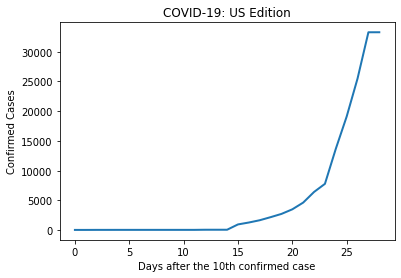

In [12]:
plt.plot(US.index, US['Confirmed'], linewidth = 2)
plt.title("COVID-19: US Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.show()

We should focus on 3 main countries for now 

In [13]:
all_countries = list(covid["Country/Region"].unique())
all_countries 

['Thailand',
 'Japan',
 'Singapore',
 'Nepal',
 'Malaysia',
 'Canada',
 'Australia',
 'Cambodia',
 'Sri Lanka',
 'Germany',
 'Finland',
 'United Arab Emirates',
 'Philippines',
 'India',
 'Italy',
 'Sweden',
 'Spain',
 'Belgium',
 'Egypt',
 'Lebanon',
 'Iraq',
 'Oman',
 'Afghanistan',
 'Bahrain',
 'Kuwait',
 'Algeria',
 'Croatia',
 'Switzerland',
 'Austria',
 'Israel',
 'Pakistan',
 'Brazil',
 'Georgia',
 'Greece',
 'North Macedonia',
 'Norway',
 'Romania',
 'Estonia',
 'San Marino',
 'Belarus',
 'Iceland',
 'Lithuania',
 'Mexico',
 'New Zealand',
 'Nigeria',
 'Ireland',
 'Luxembourg',
 'Monaco',
 'Qatar',
 'Ecuador',
 'Azerbaijan',
 'Armenia',
 'Dominican Republic',
 'Indonesia',
 'Portugal',
 'Andorra',
 'Latvia',
 'Morocco',
 'Saudi Arabia',
 'Senegal',
 'Argentina',
 'Chile',
 'Jordan',
 'Ukraine',
 'Hungary',
 'Liechtenstein',
 'Poland',
 'Tunisia',
 'Bosnia and Herzegovina',
 'Slovenia',
 'South Africa',
 'Bhutan',
 'Cameroon',
 'Colombia',
 'Costa Rica',
 'Peru',
 'Serbia',
 'Sl

In [14]:
china = covid.loc[covid['Country/Region'] == "China"]
china[['Date']] = china['Date'].apply(pd.to_datetime)
china = china.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
china = china.groupby(col, as_index=False).Confirmed.sum()
china = china.loc[china["Confirmed"] > 10.0] 
china = china.reset_index(drop=True)


italy = covid.loc[covid['Country/Region'] == "Italy"]
italy[['Date']] = italy['Date'].apply(pd.to_datetime)
italy = italy.sort_values(['Date'], ascending=[True])
col = ["Country/Region","Date"]
italy = italy.groupby(col, as_index=False).Confirmed.sum()
italy = italy.loc[italy["Confirmed"] > 10.0] 
italy = italy.reset_index(drop=True)

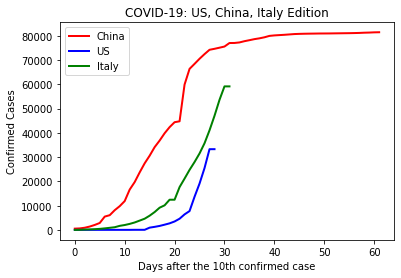

In [15]:
plt.plot(china.index, china['Confirmed'], 'r', linewidth = 2, label="China")
plt.plot(US.index, US['Confirmed'],'b',linewidth = 2, label="US")
plt.plot(italy.index, italy['Confirmed'],'g',linewidth = 2, label="Italy")
plt.title("COVID-19: US, China, Italy Edition")
plt.xlabel("Days after the 10th confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

Moving forward, you can call "US", "Italy", or "China" to work for either country

### Let's focus on China 

In [16]:
china_train = china[["Confirmed"]]

In [17]:
china_train

,Confirmed
0,548.0
1,643.0
2,920.0
3,1406.0
4,2075.0
...,...
57,81156.0
58,81250.0
59,81305.0
60,81397.0


In [18]:
train, test  = train_test_split(china_train, test_size = 0.2, shuffle=False)


## Transform the Data

In [20]:
china = china[["Date", "Confirmed"]]

In [22]:
china

,Date,Confirmed
0,2020-01-22,548.0
1,2020-01-23,643.0
2,2020-01-24,920.0
3,2020-01-25,1406.0
4,2020-01-26,2075.0
...,...,...
57,2020-03-19,81156.0
58,2020-03-20,81250.0
59,2020-03-21,81305.0
60,2020-03-22,81397.0


In [24]:
china.Date = pd.to_datetime(china.Date)

In [25]:
china = china.set_index("Date")

In [26]:
china

,Confirmed
Date,
2020-01-22,548.0
2020-01-23,643.0
2020-01-24,920.0
2020-01-25,1406.0
2020-01-26,2075.0
...,...
2020-03-19,81156.0
2020-03-20,81250.0
2020-03-21,81305.0


In [28]:
train_data = china[:len(china)-12]
test_data = china[len(china)-12:]

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
38/38 [==============================] - 1s 17ms/step - loss: 0.1515
Epoch 2/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 3/20
38/38 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 4/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 5/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 6/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 8/20
38/38 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 9/20
38/38 [==============================] - 0s 12ms/step - loss: 0.0037
Epoch 10/20
38/38 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 11/20
38/38 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 12/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0

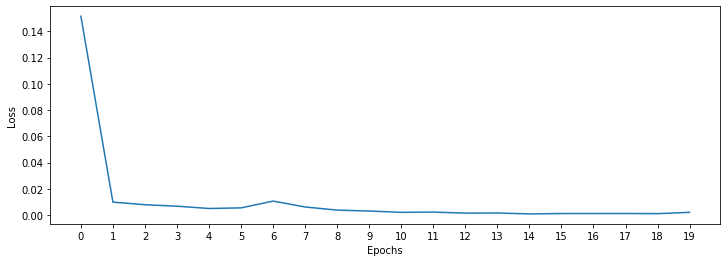

In [32]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [33]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [34]:
lstm_predictions_scaled

[array([1.0166202], dtype=float32),
 array([1.0188677], dtype=float32),
 array([1.02079], dtype=float32),
 array([1.022585], dtype=float32),
 array([1.0242698], dtype=float32),
 array([1.0258482], dtype=float32),
 array([1.0273176], dtype=float32),
 array([1.0287023], dtype=float32),
 array([1.030003], dtype=float32),
 array([1.0312321], dtype=float32),
 array([1.0323988], dtype=float32),
 array([1.0335397], dtype=float32)]

In [35]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[82256.8120513 ],
       [82437.45615125],
       [82591.95313394],
       [82736.22696745],
       [82871.63818336],
       [82998.49338031],
       [83116.60093415],
       [83227.88666773],
       [83332.42723072],
       [83431.21906877],
       [83524.9903537 ],
       [83616.68251646]])

In [36]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2020-03-12,80932.0,82256.812051
2020-03-13,80945.0,82437.456151
2020-03-14,80977.0,82591.953134
2020-03-15,81003.0,82736.226967
2020-03-16,81033.0,82871.638183
2020-03-17,81058.0,82998.493380
2020-03-18,81102.0,83116.600934
2020-03-19,81156.0,83227.886668
2020-03-20,81250.0,83332.427231


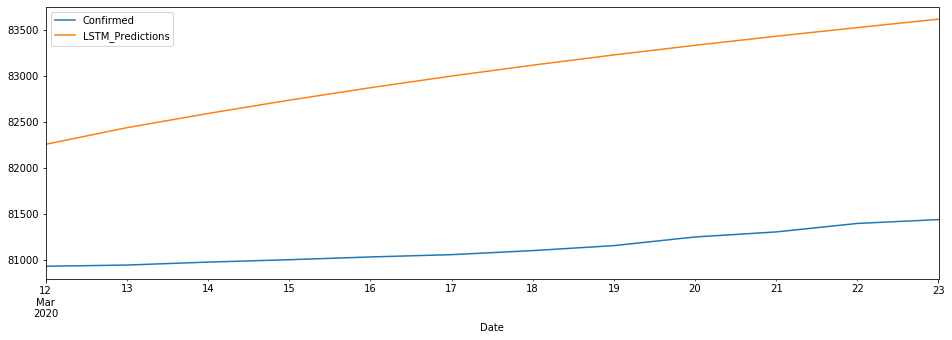

In [38]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);